In [1]:
dataset <- read.csv('mahasiswa.csv')
dataset

Id,Penghasilan,Pengeluaran
<int>,<dbl>,<dbl>
1,18.76,9.68
2,8.35,4.52
3,17.03,10.11
4,8.23,9.25
5,16.89,6.99
6,15.19,7.20
7,9.03,9.35
8,17.99,7.10
9,17.09,10.54


In [2]:
summary(dataset)

       Id          Penghasilan      Pengeluaran    
 Min.   :  1.00   Min.   : 4.620   Min.   : 3.440  
 1st Qu.: 25.75   1st Qu.: 9.617   1st Qu.: 7.393  
 Median : 50.50   Median :14.805   Median : 8.600  
 Mean   : 50.50   Mean   :13.779   Mean   : 8.381  
 3rd Qu.: 75.25   3rd Qu.:17.045   3rd Qu.: 9.807  
 Max.   :100.00   Max.   :19.690   Max.   :11.290  

In [3]:
membership.trapezoid_descend <- function(x_min, x_max) {
    return(function(x) {
        val <- 1
        if (x > x_max) {
            val <- 0
        } else if (x > x_min && x <= x_max) {
            val <- (x_max - x) / (x_max - x_min)
        }
        return(val)
    })
}

In [4]:
membership.trapezoid_ascend <- function(x_min, x_max) {
    return(function(x) {
        val <- 1
        if (x <= x_min) {
            val <- 0
        } else if (x > x_min && x <= x_max) {
            val <- (x - x_min) / (x_max - x_min)
        }
        return(val)
    })
}

In [5]:
membership.trapezoid <- function(x_min, x_max, x_minavg, x_maxavg) {
    return(function(x) {
        val <- 1
        if (x <= x_min || x >= x_max) {
            val <- 0
        } else if (x > x_min && x < x_minavg) {
            val <- (x - x_min) / (x_minavg - x_min)
        } else if (x > x_maxavg && x < x_max) {
            val <- -(x - x_max) / (x_max - x_maxavg)
        }
        return(val)
    })
}

In [6]:
income_membership.low <- membership.trapezoid_descend(5, 7)
income_membership.average <- membership.trapezoid(6, 14, 8, 12)
income_membership.high <- membership.trapezoid_ascend(11, 16)
income_membership <- function(type, income) {
    value <- income_membership.low(income)
    if (type == "average") {
        value <- income_membership.average(income)
    } else if (type == "high") {
        value <- income_membership.high(income)
    }
    return(value)
}

In [7]:
expense_membership.low <- membership.trapezoid_descend(4, 6)
expense_membership.average <- membership.trapezoid(5, 9, 6, 8)
expense_membership.high <- membership.trapezoid_ascend(8, 10)
expense_membership <- function(type, expense) {
    value <- expense_membership.low(expense)
    if (type == "average") {
        value <- expense_membership.average(expense)
    } else if (type == "high") {
        value <- expense_membership.high(expense)
    }
    return(value)
}

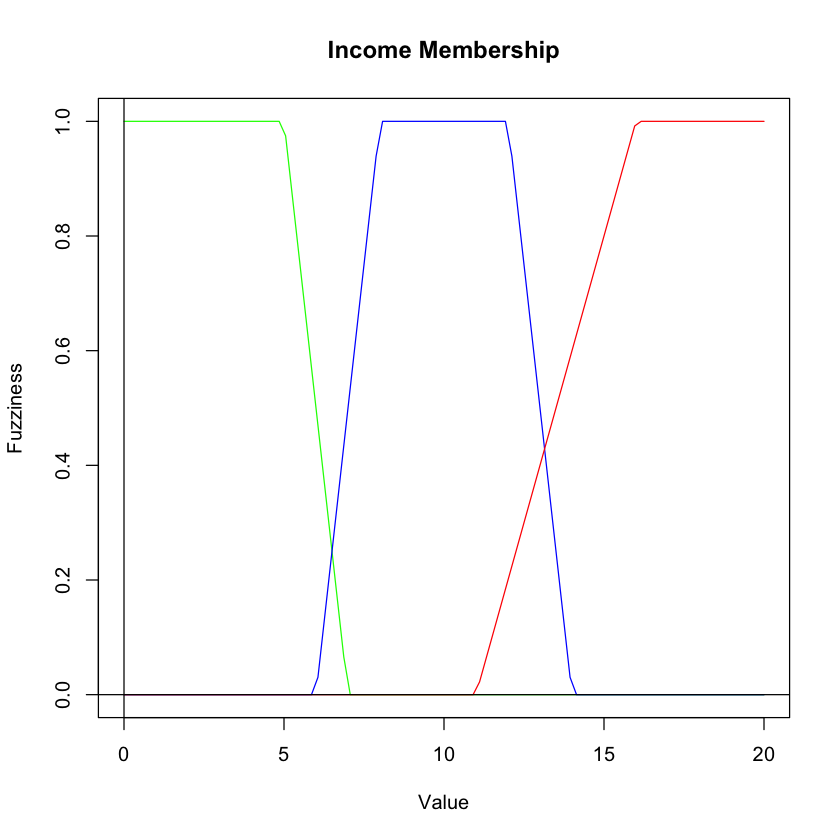

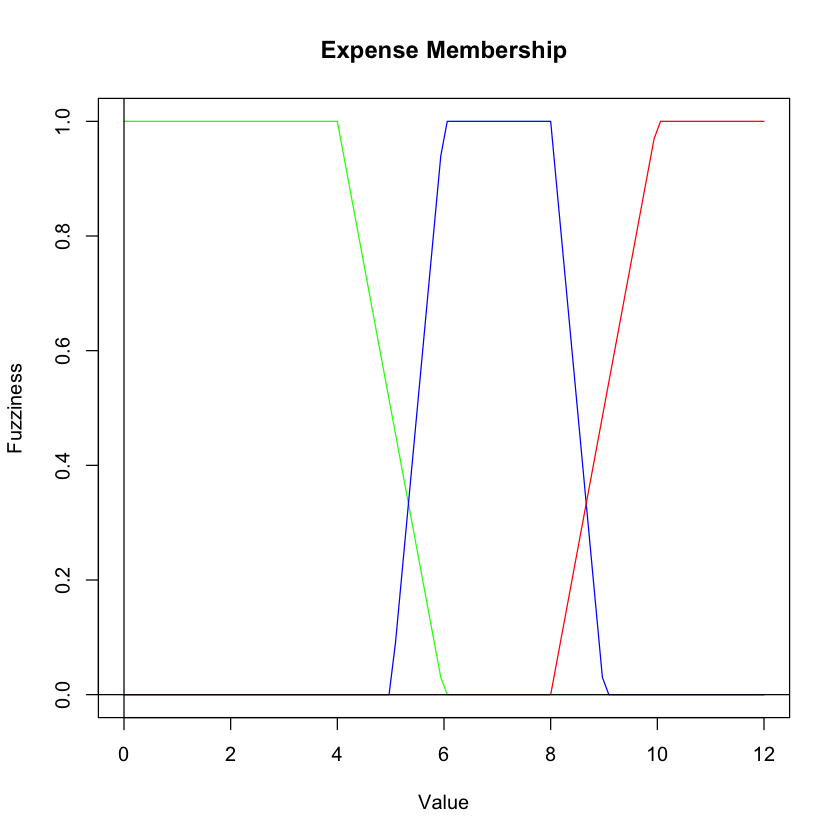

In [8]:
a <- seq(0, 20, length.out = 100)
b <- seq(0, 12, length.out = 100)
c <- lapply(a, income_membership.low)
d <- lapply(a, income_membership.average)
e <- lapply(a, income_membership.high)
f <- lapply(b, expense_membership.low)
g <- lapply(b, expense_membership.average)
h <- lapply(b, expense_membership.high)

plot(a, c, type = "l", ylab = "Fuzziness", xlab = "Value", col = "green")
title("Income Membership")
lines(a, d, col = "blue")
lines(a, e, col = "red")
abline(h = 0)
abline(v = 0)

plot(b, f, type = "l", ylab = "Fuzziness", xlab = "Value", col = "green")
title("Expense Membership")
lines(b, g, col = "blue")
lines(b, h, col = "red")
abline(h = 0)
abline(v = 0)

In [9]:
rules <- read.csv('fuzzy-rules.csv')
rules

id,income,expense,result
<int>,<chr>,<chr>,<chr>
1,low,low,consider
2,low,average,accept
3,low,high,accept
4,average,low,reject
5,average,average,consider
6,average,high,accept
7,high,low,reject
8,high,average,reject
9,high,high,consider


In [10]:
generate_fuzzy_table <- function(data, rules) {
    data_id <- c()
    data_id[1:nrow(rules)] <- data$Id
    income <- c()
    income[1:nrow(rules)] <- data$Penghasilan
    expense <- c()
    expense[1:nrow(rules)] <- data$Pengeluaran
    income_fuzzy <- c()
    expense_fuzzy <- c()
    result_fuzzy <- c()
    for (i in 1:nrow(rules)) {
        income_fuzzy <- c(income_fuzzy, income_membership(rules[i, "income"], data$Penghasilan))
        expense_fuzzy <- c(expense_fuzzy, expense_membership(rules[i, "expense"], data$Pengeluaran))
        current_length <- length(income_fuzzy)
        result_fuzzy <- c(result_fuzzy, min(income_fuzzy[current_length], expense_fuzzy[current_length]))
    }
    return(data.frame(
        data_id = data_id,
        id = rules$id,
        income = income,
        income_rule = rules$income, 
        income_fuzzy = income_fuzzy,
        expense = expense,
        expense_rule = rules$expense,
        expense_fuzzy = expense_fuzzy,
        result_rule = rules$result,
        result_fuzzy = result_fuzzy
    ))
}

In [12]:
new_dataset <- data.frame()
for (i in 1:nrow(dataset)) {
    fuzzy_table <- generate_fuzzy_table(dataset[i, ], rules)
    new_dataset <- rbind(new_dataset, fuzzy_table)
}
new_dataset

data_id,id,income,income_rule,income_fuzzy,expense,expense_rule,expense_fuzzy,result_rule,result_fuzzy
<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,1,18.76,low,0,9.68,low,0.000,consider,0.00
1,2,18.76,low,0,9.68,average,0.000,accept,0.00
1,3,18.76,low,0,9.68,high,0.840,accept,0.00
1,4,18.76,average,0,9.68,low,0.000,reject,0.00
1,5,18.76,average,0,9.68,average,0.000,consider,0.00
1,6,18.76,average,0,9.68,high,0.840,accept,0.00
1,7,18.76,high,1,9.68,low,0.000,reject,0.00
1,8,18.76,high,1,9.68,average,0.000,reject,0.00
1,9,18.76,high,1,9.68,high,0.840,consider,0.84


In [13]:
inference <- function(data) {
    selected_column <- c('data_id', 'result_rule', 'result_fuzzy')
    reject <- data$result_rule == 'reject'
    consider <- data$result_rule == 'consider'
    accept <- data$result_rule == 'accept'
    data <- data[selected_column]
    reject_data <- data[reject, selected_column]
    consider_data <- data[consider, selected_column]
    accept_data <- data[accept, selected_column]
    id = data[1, 'data_id']
    return(data.frame(
        id = id,
        reject = max(reject_data$result_fuzzy),
        consider = max(consider_data$result_fuzzy),
        accept = max(accept_data$result_fuzzy)
    ))
}

In [14]:
fuzzy_output_df <- data.frame()
for (i in seq(1, nrow(new_dataset), 9)) {
    inferred_data <- inference(new_dataset[seq(i, i+8),])
    fuzzy_output_df <- rbind(fuzzy_output_df, inferred_data)
}
fuzzy_output_df

id,reject,consider,accept
<int>,<dbl>,<dbl>,<dbl>
1,0.000,0.840,0.000
2,0.740,0.000,0.000
3,0.000,1.000,0.000
4,0.000,0.000,0.625
5,1.000,0.000,0.000
6,0.838,0.000,0.000
7,0.000,0.000,0.675
8,1.000,0.000,0.000
9,0.000,1.000,0.000


In [24]:
result_membership.reject <- membership.trapezoid_descend(40, 60)
result_membership.consider <- membership.trapezoid(55, 80, 60, 70)
result_membership.accept <- membership.trapezoid_ascend(75, 85)

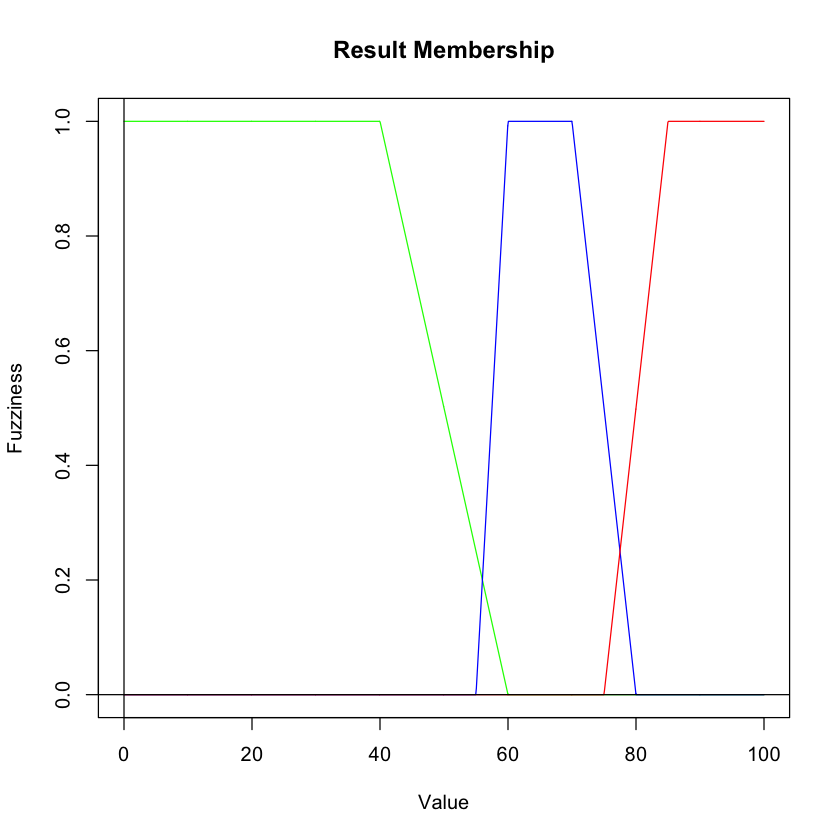

In [66]:
sequence <- seq(0, 100, length.out = 1000)
result_sequence.reject <- lapply(sequence, result_membership.reject)
result_sequence.consider <- lapply(sequence, result_membership.consider)
result_sequence.accept <- lapply(sequence, result_membership.accept)

plot(sequence, result_sequence.reject, type = "l", ylab = "Fuzziness", xlab = "Value", col = "green")
title("Result Membership")
lines(sequence, result_sequence.consider, col = "blue")
lines(sequence, result_sequence.accept, col = "red")
abline(h = 0)
abline(v = 0)

In [179]:
result_list <- list(sequence, 
                    result_sequence.reject, 
                    result_sequence.consider, 
                    result_sequence.accept
                   )
result_df <- data.frame(matrix(unlist(result_list), nrow = length(sequence)))
colnames(result_df) <- c('x', 'reject', 'consider', 'accept')

In [104]:
replace_value <- function(table, row) {
    for (i in 1:nrow(table)) {
        if (row['reject'] <= table[i, 'reject']) table[i, 'reject'] <- row['reject']
        if (row['consider'] <= table[i, 'consider']) table[i, 'consider'] <- row['consider']
        if (row['accept'] <= table[i, 'accept']) table[i, 'accept'] <- row['accept']
    }
    return(table)
} 

In [171]:
center_of_gravity <- function(table, row) {
    new_table <- replace_value(table, row)
    new_table[, 'max'] <- apply(new_table[c('reject', 'consider', 'accept')], 1, max)
    new_table[, 'max*x'] <- apply(new_table, 1, function(x) {
        return(x['max'] * x['x'])
    })
    sum(new_table['max*x'])/sum(new_table['max'])
}

center_of_gravity(result_df, test_row)

[1] 83.48629

In [177]:
result_crisp_df <- data.frame()
for (i in 1:nrow(fuzzy_output_df)) {
    new_row <- list(
        id = fuzzy_output_df[i, 'id'],
        value = center_of_gravity(result_df, fuzzy_output_df[i, ])
    )
    result_crisp_df <- rbind(result_crisp_df, new_row)
}
result_crisp_df

,id,value
,<int>,<dbl>
1,1,66.56788
2,2,26.44833
3,3,66.42854
4,4,89.01327
5,5,25.30799
6,6,26.01153
7,7,89.12492
8,8,25.30799
9,9,66.42854


In [178]:
dataset

Id,Penghasilan,Pengeluaran
<int>,<dbl>,<dbl>
1,18.76,9.68
2,8.35,4.52
3,17.03,10.11
4,8.23,9.25
5,16.89,6.99
6,15.19,7.20
7,9.03,9.35
8,17.99,7.10
9,17.09,10.54
